In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

For an SDE

$$ dX = a(X, t) dt + b(X, t) dW_t, $$

there is a transition density, $p(y, s; x, t)$, describing the probability density for a solution that has value $y$ at time $s$ to have value $x$ at time $t$, with $s \leq t$. This transition density, which we will call $p$ for short, obeys the forward and backward Kolmogorov equations, provided that $a$ and $b$ are "moderately smooth functions" (Kloeden & Platen, p. 37).

Just for completeness, the forward equation is

$$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \big( a(x, t) \, p \big) + \frac{1}{2} \frac{\partial^2}{\partial x^2} \big( b^2(x, t) \, p \big), \;\;\;\textrm{keeping $y,s$ fixed},$$
and the backward equation is
$$ \frac{\partial p}{\partial s} = - a(y, s) \frac{\partial p}{\partial y} - \frac{1}{2} b(y, s)^2 \frac{\partial^2 p}{\partial y^2}, \;\;\;\textrm{keeping $x, t$ fixed}. $$

The point of the backward equation is that if we observe that a solution has value $x$, at time $t$, it can tell us the distribution of most likely values $y$, at an earlier time $t$. Or to put it in practical terms, if we observe an oil spill or a life raft or whatever, we can find the most likely locations it came from, at some earlier time, given the observation and the advection and diffusion describing the problem.

To illustrate the backward equation, I will use an SDE that I will call the forward SDE,

$$ dX = \big(v + K'(X, t) \big)\, dt + \sqrt{2K(X, t)}\, dW_t, $$

where $K(x, t)$ is the diffusivity, $K' = \partial K / \partial x$, and $v$ is a constant advection velocity. It is left as an exercise to the reader to verify that the forward Kolmogorov equation in this case becomes the advection-diffusion equation.

Additionally, I will use an SDE which I will call the backward SDE (see Eq. (20) in Shah et al, 2007),
$$ dX = \big(-v + K'(X, t) \big)\, dt + \sqrt{2K(X, t)}\, dW_t. $$
Basically this equation has the backward Kolmogorov equation for the forward SDE as it's backward Kolmogorov equation, so that modelling the backward SDE forwards in time is equivalent to modelling the forwards SDE backwards in time. If that makes sense.

To try to make this a bit more concrete, I will do three different numerical demos. For all three, I will assume that we have made an observation of a distribution of solutions, uniformly distributed on the interval $[x_0 - \Delta x, x_0 + \Delta x]$, and I will be asking where these particles most likely came from, given that their motion (forwards in time) is controlled by the forward SDE. I will do the following:
 * Starting out with a uniform distribution $[x_0 - \Delta x, x_0 + \Delta x]$, at time $t$, I will use the backward SDE to find the distribution at the earlier time $s$.
 * Starting out with a very wide, uniform distribution at time $s$, I will use the forward SDE to model the transport until the later time $t$, and then keep only those solutions that ended up inside the interval $[x_0 - \Delta x, x_0 + \Delta x]$ at time $t$, and look at their
initial distribution at time $s$.
 * Starting with $$p(y,s; x,t) = \left\{ \begin{array}{lcl} 1 / 2\Delta x & \mathrm{if} & x \in [x_0 - \Delta x, x_0 + \Delta x] \\ 0 & \mathrm{otherwise} \end{array} \right., $$ I will solve the backward Kolmogorov equation numerically (using finite differences) to find the distribution of initial positions.

The results 

In my line of work, I deal with advection-diffusion problems where the functions $a$ and $b$ are chosen to be consistent with the advection-diffusion equation. In fact, $a$ and $b$ are chosen such that the forward Kolmogorov equation _is_ the advection-diffusion equation.

In [3]:
# Define diffusivity and derivative of diffusivity
def K(z, t):
    K0 = 1e-3
    K1 = 5e-3
    return K0 + K1*(1 + np.sin(2*np.pi*z))

def dKdz(z, t):
    K1 = 5e-3
    return 2*np.pi * K1*np.cos(2*np.pi*z)

# Drift function for SDE
def a(z, t):
    v = 0.01
    return v + dKdz(z, t)

def a_(z, t):
    v = -0.01
    return v + dKdz(z, t)

def b(z, t):
    return np.sqrt(2*K(z, t))

def EM(z, t, dt, a, b):
    dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=len(z))
    return z + a(z, t)*dt + b(z, t)*dW

In [35]:
Np = 1000000
dt = 0.01
Tmax = 5.
z0 = 0.5

# Derived variables
Nt = int(Tmax / dt)

# Model in reverse
Z_ = z0 + np.random.uniform(low=-0.2, high=0.2, size=Np)
t = Tmax
for n in range(Nt):
    Z_ = EM(Z_, t, dt, a_, b)
    t -= dt

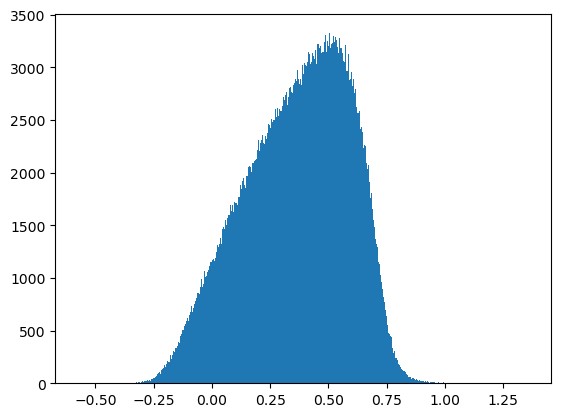

In [10]:
_ = plt.hist(Z_, bins=1000)

In [36]:
Np = 1000000
dt = 0.01
Tmax = 5.
z0 = 0.5

# Derived variables
Nt = int(Tmax / dt)

# Model forwards
Z0 = np.random.uniform(low=-1, high=1, size=Np)
Z = np.copy(Z0)
t = Tmax
for n in range(Nt):
    Z = EM(Z, t, dt, a, b)
    t += dt

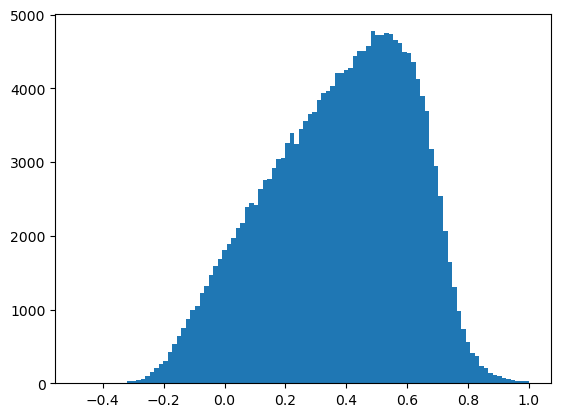

In [37]:
# Find distribution of particles that ended up within a small distance of z0
mask = np.abs(Z - z0) < 0.2


_ = plt.hist(Z0[mask], bins=100)

In [38]:
Tmax = 5
z0 = 0.5
# z-axis
zc, dz = np.linspace(-2, 2, 1001, retstep=True)
# timestep
dt = 0.0001
# timesteps
Nt = int(Tmax/dt)
# "initial" condition (actually final condition)
p0 = np.where(np.abs(zc - z0) < 0.2, 1., 0.) / (2*0.2)


p = p0.copy()
t = 5.
for i in range(Nt):
    p[1:-1] = p[1:-1] + dt*(
        + a(zc[1:-1], t) * (p[2:] - p[:-2]) / (2*dz)
        + (1/2)*b(zc[1:-1], t)**2 * (p[2:] - 2*p[1:-1] + p[:-2]) / dz**2
    )
    t -= dt





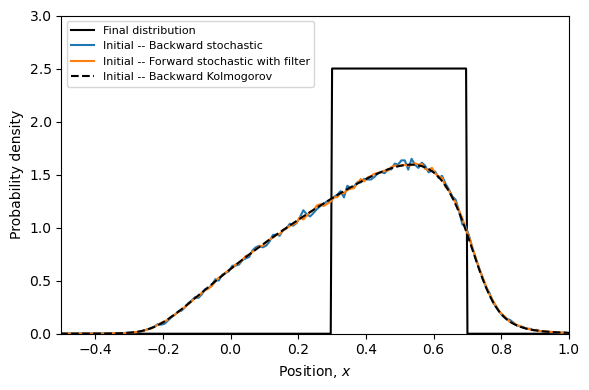

In [43]:
bins = np.linspace(-0.5, 1, 151)
mids = bins[:-1] + (bins[1] - bins[0])/2

c, _ = np.histogram(Z0[mask], bins=bins, density=True)
c_, _ = np.histogram(Z_, bins=bins, density=True)

fig = plt.figure(figsize=(6,4))
plt.plot(zc, p0, c='k', label='Final distribution')
plt.plot(mids, c, label='Initial -- Backward stochastic')
plt.plot(mids, c_, label='Initial -- Forward stochastic with filter')
plt.plot(zc, p, '--', c='k', label='Initial -- Backward Kolmogorov')
plt.legend(loc='upper left', fontsize=8)
plt.xlim(-0.5, 1.)
plt.ylim(0, 3)
plt.ylabel('Probability density')
plt.xlabel('Position, $x$')
plt.tight_layout()
plt.savefig('numerical_examples.png', dpi=300)

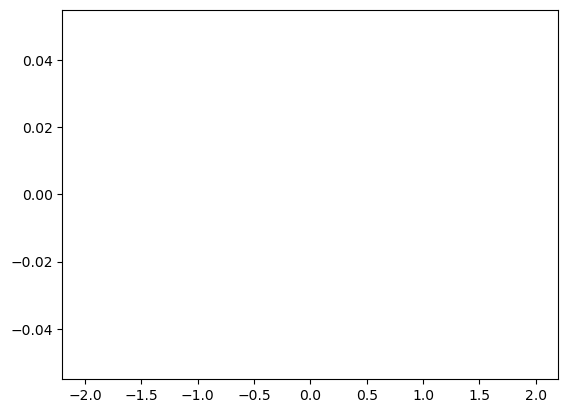

In [20]:
plt.plot(zc, p)